In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

plt.style.use('dark_background')

In [2]:
eth = pd.read_csv("ETH_price.csv")
eth['date'] = pd.to_datetime(eth['Date(UTC)'])
eth = eth[['date', 'Value']].rename(columns={'Value': 'ETH_close'})

# External market features (same as BTC experiment)
ext = pd.read_csv("btc_full_sp500_gold_dxy_close_2017_onward.csv")
ext['date'] = pd.to_datetime(ext['date'])
ext = ext[['date', 'SP500_close', 'GOLD_close', 'DXY_close']]

# Merge on date and sort
df = pd.merge(eth, ext, on='date', how='inner').sort_values('date')
df = df.set_index('date')

print('Col Name: ', df.columns.tolist())

# Add technical indicators for better feature engineering
# Moving averages
df['ETH_MA_7'] = df['ETH_close'].rolling(window=7).mean()
df['ETH_MA_14'] = df['ETH_close'].rolling(window=14).mean()
df['ETH_MA_30'] = df['ETH_close'].rolling(window=30).mean()

# Momentum indicators
df['ETH_momentum_7'] = df['ETH_close'].pct_change(7)
df['ETH_momentum_14'] = df['ETH_close'].pct_change(14)

# Volatility (rolling std)
df['ETH_volatility_7'] = df['ETH_close'].rolling(window=7).std()
df['ETH_volatility_14'] = df['ETH_close'].rolling(window=14).std()

# RSI-like indicator (price position in recent range)
df['ETH_high_7'] = df['ETH_close'].rolling(window=7).max()
df['ETH_low_7'] = df['ETH_close'].rolling(window=7).min()
df['ETH_position'] = (df['ETH_close'] - df['ETH_low_7']) / (df['ETH_high_7'] - df['ETH_low_7'] + 1e-10)

# Rate of change
df['ETH_roc'] = df['ETH_close'].pct_change(1)

# External asset momentum
df['SP500_momentum'] = df['SP500_close'].pct_change(7)
df['GOLD_momentum'] = df['GOLD_close'].pct_change(7)
df['DXY_momentum'] = df['DXY_close'].pct_change(7)

# Drop rows with NaN from rolling calculations
df = df.dropna()

print(f"Data shape after feature engineering: {df.shape}")
df.tail()

Col Name:  ['ETH_close', 'SP500_close', 'GOLD_close', 'DXY_close']
Data shape after feature engineering: (2201, 18)


,ETH_close,SP500_close,GOLD_close,DXY_close,ETH_MA_7,ETH_MA_14,ETH_MA_30,ETH_momentum_7,ETH_momentum_14,ETH_volatility_7,ETH_volatility_14,ETH_high_7,ETH_low_7,ETH_position,ETH_roc,SP500_momentum,GOLD_momentum,DXY_momentum
date,,,,,,,,,,,,,,,,,,
2025-11-10,3566.73,6832.430176,4111.799805,99.620003,3496.658571,3706.394286,3973.624333,-0.062460,-0.079580,193.852425,265.463934,3846.74,3286.89,0.499848,0.038558,0.001479,0.027616,0.000904
2025-11-11,3416.51,6846.609863,4106.799805,99.459999,3435.197143,3678.529286,3949.295333,-0.111843,-0.102482,117.542058,274.456328,3603.83,3286.89,0.408973,-0.042117,0.000937,0.031289,-0.003407
2025-11-12,3414.45,6850.919922,4204.399902,99.480003,3408.142857,3646.820000,3918.092667,-0.052550,-0.115056,91.073849,277.704392,3566.73,3286.89,0.455832,-0.000603,-0.000153,0.051021,-0.003905
2025-11-13,3230.03,6737.490234,4186.899902,99.180000,3400.020000,3596.376429,3876.164000,-0.017299,-0.179412,105.140180,285.129214,3566.73,3230.03,0.000000,-0.054012,-0.005030,0.060592,-0.010377
2025-11-14,3110.38,6734.109863,4087.600098,99.269997,3355.200000,3524.155714,3829.310000,-0.091626,-0.245323,150.319347,269.519561,3566.73,3110.38,0.000000,-0.037043,-0.009149,0.026958,-0.009281


In [3]:
# Feature Columns and Target Column (including new technical indicators)
feature_cols = ['ETH_close', 'SP500_close', 'GOLD_close', 'DXY_close',
                'ETH_MA_7', 'ETH_MA_14', 'ETH_MA_30',
                'ETH_momentum_7', 'ETH_momentum_14',
                'ETH_volatility_7', 'ETH_volatility_14',
                'ETH_position', 'ETH_roc',
                'SP500_momentum', 'GOLD_momentum', 'DXY_momentum']

# Create price change target (percentage return)
# Predicting price change is often better than predicting absolute price
df['ETH_price_change_pct'] = df['ETH_close'].pct_change(1)  # 1-day percentage return
df['ETH_prev_close'] = df['ETH_close'].shift(1)  # Previous day's close (needed to convert back)

# Drop first row which has NaN from shift/pct_change
df = df.dropna()

target_col = 'ETH_price_change_pct'  # Changed to predict price changes
prev_price_col = 'ETH_prev_close'    # Keep track of previous price for conversion

print(f"Total features: {len(feature_cols)}")
print(f"Target: {target_col} (1-day percentage return)")
print(f"Will convert predictions back to absolute prices using previous close")

X_all = df[feature_cols].values.astype(float)
y_all = df[[target_col]].values.astype(float)
prev_close_all = df[prev_price_col].values.astype(float)  # Previous prices for conversion

train_size = df.loc[: "2024-12-31"].shape[0]
test_size  = df.loc["2025-01-01":].shape[0]

print('Total samples:', len(df))
print('Train size   :', train_size)
print('Test size    :', test_size)

X_train_raw = X_all[:train_size]
X_test_raw  = X_all[train_size:]
y_train_raw = y_all[:train_size]
y_test_raw  = y_all[train_size:]
prev_close_train = prev_close_all[:train_size]
prev_close_test = prev_close_all[train_size:]

# Store actual close prices for comparison
actual_close_train = df['ETH_close'].values[:train_size]
actual_close_test = df['ETH_close'].values[train_size:]

X_train_raw.shape, X_test_raw.shape, y_train_raw.shape, y_test_raw.shape

Total features: 16
Target: ETH_price_change_pct (1-day percentage return)
Will convert predictions back to absolute prices using previous close
Total samples: 2200
Train size   : 1981
Test size    : 219


((1981, 16), (219, 16), (1981, 1), (219, 1))

In [4]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_all_scaled   = scaler_X.transform(X_all)

y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_all_scaled   = scaler_y.transform(y_all)

X_train_scaled.shape, X_all_scaled.shape, y_train_scaled.shape, y_all_scaled.shape

((1981, 16), (2200, 16), (1981, 1), (2200, 1))

In [5]:
time_steps = 30

def create_sequences_XGBoost(X, y, time_steps):
    """
    Create sequences for XGBoost by flattening time windows.
    Each sample becomes a flat feature vector of shape (time_steps * n_features,)
    Also includes statistical features from the time window for better learning.
    """
    X_list, y_list = [], []
    for i in range(time_steps, len(X)):
        # Get the time window
        window = X[i-time_steps:i]

        # Flatten the time window
        X_flat = window.flatten()

        # Add statistical features from the window (mean, std, min, max of each feature)
        stats_features = []
        for feat_idx in range(window.shape[1]):
            feat_window = window[:, feat_idx]
            stats_features.extend([
                feat_window.mean(),      # Mean
                feat_window.std(),       # Std deviation
                feat_window.min(),       # Min
                feat_window.max(),       # Max
                feat_window[-1] - feat_window[0],  # Change over window
                feat_window[-1] / (feat_window[0] + 1e-10)  # Ratio
            ])

        # Combine flattened window + statistical features
        X_combined = np.concatenate([X_flat, np.array(stats_features)])
        X_list.append(X_combined)
        y_list.append(y[i])

    return np.array(X_list), np.array(y_list)

X_seq, y_seq = create_sequences_XGBoost(X_all_scaled, y_all_scaled, time_steps)
print('X_seq:', X_seq.shape, 'y_seq:', y_seq.shape)

split_idx = train_size - time_steps
x_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
x_test  = X_seq[split_idx:]
y_test  = y_seq[split_idx:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

X_seq: (2170, 576) y_seq: (2170, 1)


((1951, 576), (1951, 1), (219, 576), (219, 1))

In [6]:
# Flatten y_train and y_test for XGBoost (it expects 1D array)
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print('n_features (after flattening):', x_train.shape[1])
print('Training samples:', x_train.shape[0])
print('Test samples:', x_test.shape[0])

# Initialize XGBoost Regressor with optimized parameters for time series
# Parameters tuned to better capture volatility and trends
model = xgb.XGBRegressor(
    n_estimators=500,       # High number of trees for better learning
    max_depth=10,           # Deeper trees to capture complex patterns
    learning_rate=0.03,     # Higher learning rate for faster adaptation
    subsample=0.9,          # Use more data for each tree
    colsample_bytree=0.9,   # Use more features
    colsample_bylevel=0.9,  # Column sampling at each level
    min_child_weight=1,     # Lower threshold for splits (more sensitive)
    gamma=0,                # No minimum loss reduction (allow more splits)
    reg_alpha=0.05,         # Light L1 regularization
    reg_lambda=0.5,         # Light L2 regularization (less regularization = more sensitivity)
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse',
    objective='reg:squarederror',
    booster='gbtree'
)

print("XGBoost Model Configuration (Optimized for Time Series):")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - subsample: {model.subsample}")
print(f"  - colsample_bytree: {model.colsample_bytree}")
print(f"  - min_child_weight: {model.min_child_weight}")
print(f"  - gamma: {model.gamma}")
print(f"  - reg_alpha (L1): {model.reg_alpha}")
print(f"  - reg_lambda (L2): {model.reg_lambda}")

n_features (after flattening): 576
Training samples: 1951
Test samples: 219
XGBoost Model Configuration (Optimized for Time Series):
  - n_estimators: 500
  - max_depth: 10
  - learning_rate: 0.03
  - subsample: 0.9
  - colsample_bytree: 0.9
  - min_child_weight: 1
  - gamma: 0
  - reg_alpha (L1): 0.05
  - reg_lambda (L2): 0.5


In [7]:
# Train the model with validation monitoring
# Monitor training to prevent overfitting while allowing the model to learn complex patterns
model.fit(
    x_train, y_train_flat,
    eval_set=[(x_train, y_train_flat), (x_test, y_test_flat)],
    verbose=50  # Print every 50 iterations
)

print(f"Training completed with {model.n_estimators} estimators")

[0]	validation_0-rmse:0.06470	validation_1-rmse:0.04971
[50]	validation_0-rmse:0.04045	validation_1-rmse:0.05023
[100]	validation_0-rmse:0.02408	validation_1-rmse:0.05070
[150]	validation_0-rmse:0.01383	validation_1-rmse:0.05092
[200]	validation_0-rmse:0.00827	validation_1-rmse:0.05107
[250]	validation_0-rmse:0.00542	validation_1-rmse:0.05116
[300]	validation_0-rmse:0.00392	validation_1-rmse:0.05123
[350]	validation_0-rmse:0.00304	validation_1-rmse:0.05127
[400]	validation_0-rmse:0.00250	validation_1-rmse:0.05129
[450]	validation_0-rmse:0.00214	validation_1-rmse:0.05129
[499]	validation_0-rmse:0.00190	validation_1-rmse:0.05131
Training completed with 500 estimators


In [8]:
# Model predicts price changes (percentage returns)
train_pred_change_scaled = model.predict(x_train).reshape(-1, 1)
test_pred_change_scaled  = model.predict(x_test).reshape(-1, 1)

# Inverse transform to get actual percentage returns
train_pred_change = scaler_y.inverse_transform(train_pred_change_scaled)
test_pred_change  = scaler_y.inverse_transform(test_pred_change_scaled)
y_train_change_actual = scaler_y.inverse_transform(y_train)
y_test_change_actual  = scaler_y.inverse_transform(y_test)

# Convert predicted price changes back to absolute prices
# predicted_price = previous_price * (1 + predicted_return)
# Get previous prices for the sequences (need to align with sequence indices)
prev_close_train_seq = prev_close_train[time_steps:]
prev_close_test_seq = prev_close_test

train_pred_price = prev_close_train_seq * (1 + train_pred_change.flatten())
test_pred_price = prev_close_test_seq * (1 + test_pred_change.flatten())

# Get actual prices for comparison
y_train_actual = actual_close_train[time_steps:]
y_test_actual = actual_close_test

# Calculate metrics on absolute prices
mae = mean_absolute_error(y_test_actual, test_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_price))
print('Test MAE (on absolute prices):', mae)
print('Test RMSE (on absolute prices):', rmse)
print('Note: Model predicts price changes (%), then converts to absolute prices')

Test MAE (on absolute prices): 107.7675012390935
Test RMSE (on absolute prices): 146.69387468141977
Note: Model predicts price changes (%), then converts to absolute prices


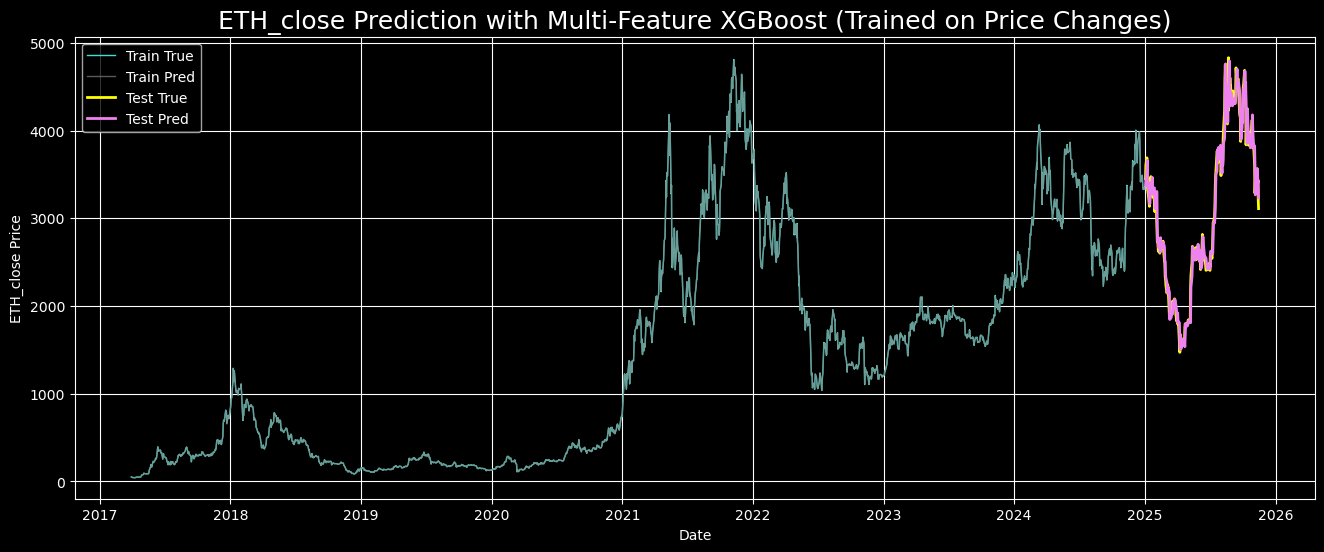

In [9]:
plt.figure(figsize=(16, 6))
plt.title('ETH_close Prediction with Multi-Feature XGBoost (Trained on Price Changes)', fontsize=18)

idx_all = df.index
idx_train = idx_all[time_steps:train_size]
idx_test  = idx_all[train_size:]

plt.plot(idx_train, y_train_actual, label='Train True', color='turquoise', linewidth=1)
plt.plot(idx_train, train_pred_price, label='Train Pred', color='gray', linewidth=1, alpha=0.7)

plt.plot(idx_test, y_test_actual, label='Test True', color='yellow', linewidth=2)
plt.plot(idx_test, test_pred_price, label='Test Pred', color='violet', linewidth=2)

plt.xlabel('Date')
plt.ylabel('ETH_close Price')
plt.legend()
plt.grid(True)
plt.show()

Total features: 576
Feature names created: 576


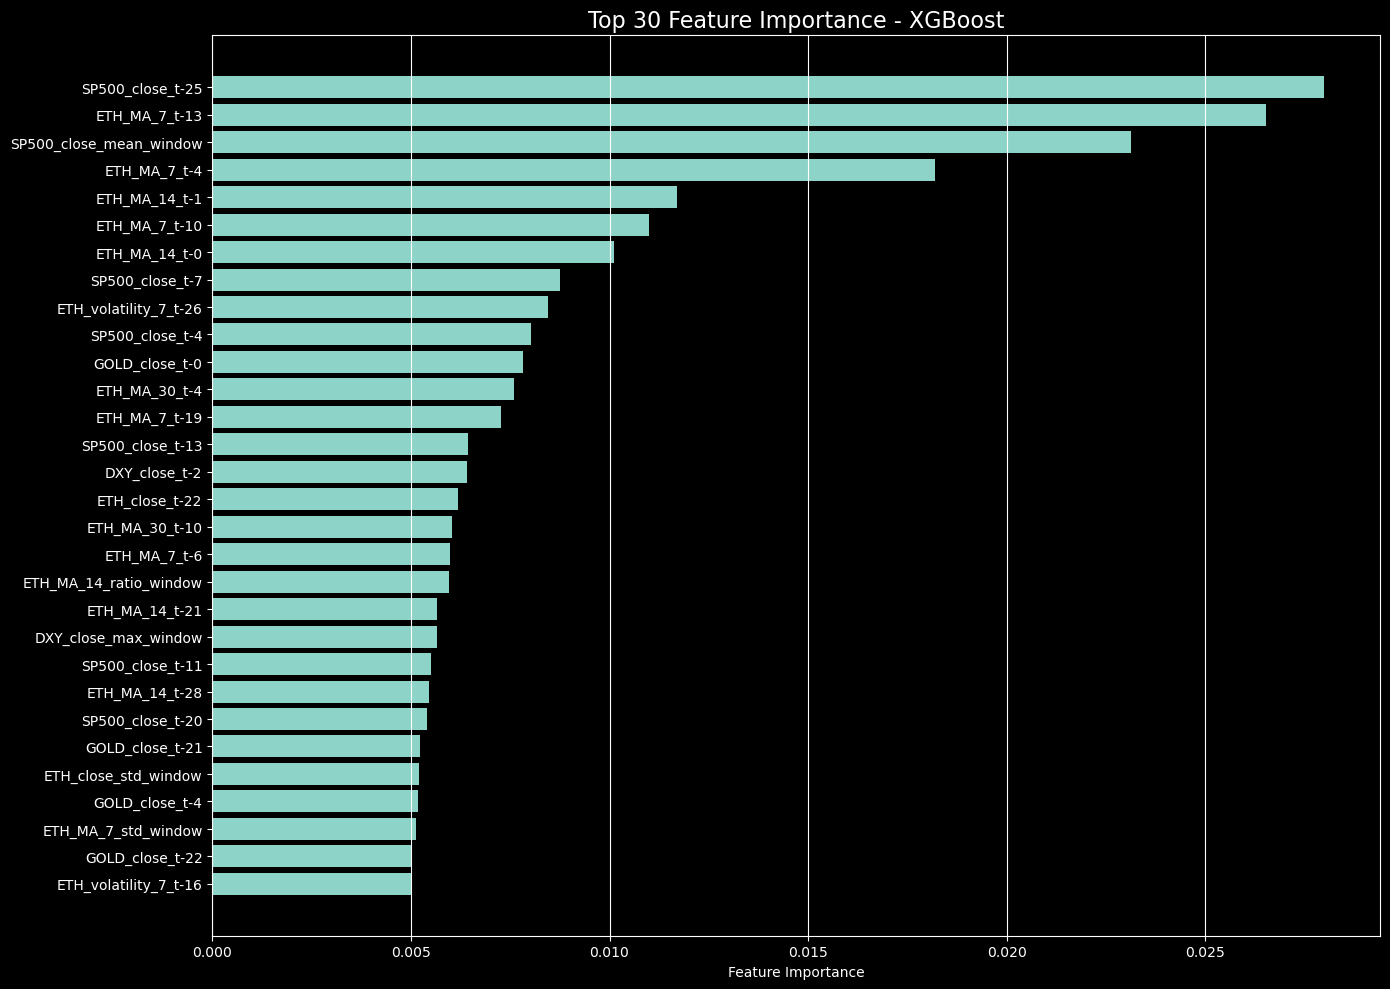

In [10]:
# Feature importance plot
feature_importance = model.feature_importances_

# Create feature names for all features
# First, names for flattened time window features
n_features_per_timestep = len(feature_cols)
feature_names = []
for t in range(time_steps):
    for f in feature_cols:
        feature_names.append(f'{f}_t-{time_steps-t-1}')

# Then, names for statistical features (mean, std, min, max, change, ratio)
stat_names = ['mean', 'std', 'min', 'max', 'change', 'ratio']
for f in feature_cols:
    for stat in stat_names:
        feature_names.append(f'{f}_{stat}_window')

# Verify we have the right number of feature names
total_features = len(feature_importance)
print(f"Total features: {total_features}")
print(f"Feature names created: {len(feature_names)}")

# Sort by importance
indices = np.argsort(feature_importance)[::-1]
top_n = 30  # Show top 30 features

# Only use indices that are within bounds
valid_indices = [i for i in indices[:top_n] if i < len(feature_names)]
if len(valid_indices) < top_n:
    print(f"Warning: Only {len(valid_indices)} feature names available, showing fewer features")

plt.figure(figsize=(14, 10))
plt.title(f'Top {len(valid_indices)} Feature Importance - XGBoost', fontsize=16)
plt.barh(range(len(valid_indices)), feature_importance[valid_indices])
plt.yticks(range(len(valid_indices)), [feature_names[i] for i in valid_indices])
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [11]:
# Calculate additional metrics on absolute prices
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train_actual, train_pred_price)
test_r2 = r2_score(y_test_actual, test_pred_price)
train_mae = mean_absolute_error(y_train_actual, train_pred_price)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred_price))

print('Training Metrics (Absolute Prices):')
print(f'  MAE : {train_mae:.2f}')
print(f'  RMSE: {train_rmse:.2f}')
print(f'  R²  : {train_r2:.4f}')
print()
print('Test Metrics (Absolute Prices):')
print(f'  MAE : {mae:.2f}')
print(f'  RMSE: {rmse:.2f}')
print(f'  R²  : {test_r2:.4f}')
print()
print('Model trained on price changes (%) then converted to absolute prices')
print('This approach is more stable and better for time series forecasting')

Training Metrics (Absolute Prices):
  MAE : 1.51
  RMSE: 3.12
  R²  : 1.0000

Test Metrics (Absolute Prices):
  MAE : 107.77
  RMSE: 146.69
  R²  : 0.9750

Model trained on price changes (%) then converted to absolute prices
This approach is more stable and better for time series forecasting
